In [57]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import pylab as py

**Download data: 'black box' predictions by random forest**

In [58]:
# URL of dataset - with predictions generated by linear regression
URL = "https://github.com/SHeidema/AMES-TRIDSA/blob/main/datasets/predictions_rf.csv?raw=true"

# Load dataset
df = (pd.read_csv(URL))

# Exploratory data analysis

Let $Y_i$ be the real sale price, and $\hat{Y_i}$ its predicted value. The residuals are defined as $\varepsilon_i = Y_i - \hat{Y_i}$

**Calculate the residuals and its summary statistics**

In [59]:
# Calculate residuals
df['Residuals'] = df['SalePrice'] - df['SalePricePrediction']

In [60]:
# Summary statistics

# Mean
mean = np.mean(df['Residuals'])
print(f"The estimated mean: {mean}")

# Median
median = np.median(df['Residuals'])
print(f"The estimated median: {median}")

# Variance
var = np.var(df['Residuals'])
print(f"The estimated variance: {var}")

#RMLSE
def rmsle(y_true, y_pred):
    log_diff = np.log1p(y_true) - np.log1p(y_pred)
    squared_log_diff = np.square(log_diff)
    mean_squared_log_diff = np.mean(squared_log_diff)
    rmsle = np.sqrt(mean_squared_log_diff)
    return rmsle

# RMSLE .
rmsle = rmsle(df['SalePrice'], df['SalePricePrediction'])
print(f"The RMSLE: {rmsle}")


The estimated mean is: 1997.6874611659475
The estimated mean is: 650.4428454217559
The estimated variance is: 384220670.9074559
The RMSLE is: 0.10960353493070887


**Investigate normality of residuals through histogram and QQ-plot**

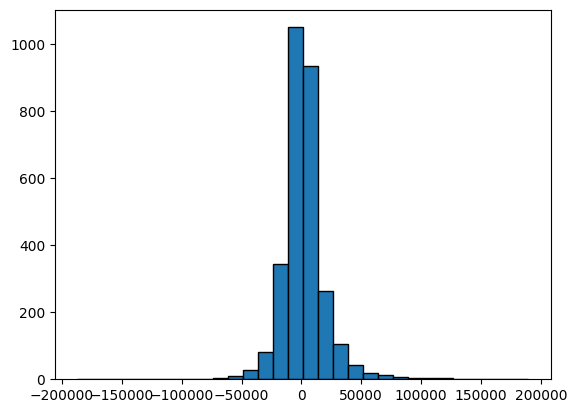

In [61]:
# Histogram
plt.hist(df['Residuals'], edgecolor='black', bins=30)
plt.show()

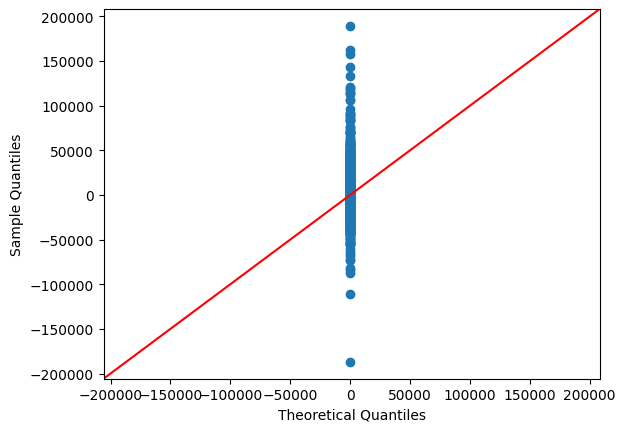

In [62]:
# QQ Plot
fig = sm.qqplot(df['Residuals'].ravel(), line='45')
plt.show()

-- Interpretation --

**Investigate relationship between $Y_i$ and $\hat{Y_i}$ through scatterplot**

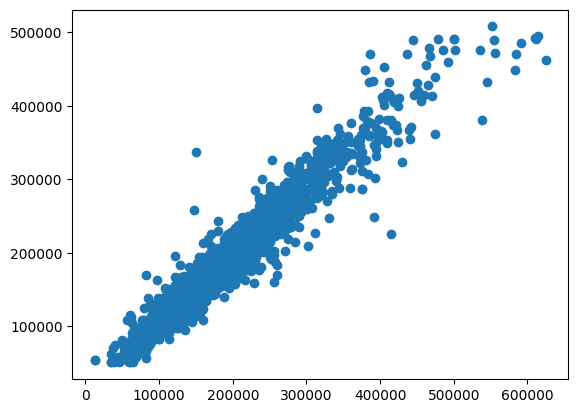

In [63]:
# Scatter plot
plt.scatter(df['SalePrice'], df['SalePricePrediction'])
plt.show()

# Model selection

**Estimate parameters of the following two models using maximum likelihood estimation. Use the likelihood ratio test and the AIC to determine the most appropriate model.**

Model 1: <br>
$Y_i \sim N(\beta_1 \cdot \hat{Y_i}, \sigma^2)$

Model 2: <br>
$Y_i \sim N(\beta_0 + \beta_1 \cdot \hat{Y_i}, \sigma^2)$

In [70]:
# Model 1
res1 = sm.OLS(df['SalePrice'], df['SalePricePrediction']).fit()

# Summary
print(res1.summary())

# Sigma^2 estimate
print(f"The estimated value for sigma^2: {res1.scale}")

# Log likelihood
logLik1 = res1.llf
print(f"The Log-Likelihood: {res1.llf}")

# Akaike information criteria
AIC1 = res1.aic
print(f"The AIC: {AIC1}")

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          2.980e+05
Date:                Tue, 04 Jul 2023   Prob (F-statistic):                        0.00
Time:                        11:43:09   Log-Likelihood:                         -33029.
No. Observations:                2925   AIC:                                  6.606e+04
Df Residuals:                    2924   BIC:                                  6.607e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [90]:
# Model 2
df_x = pd.DataFrame({'Intercept': 1, 'SalePricePrediction': df['SalePricePrediction']})

res2 = sm.OLS(df['SalePrice'], df_x).fit()

# Summary
print(res2.summary())

# Sigma^2 estimate
print(f"The estimated value for sigma^2: {res2.scale}")

# Log likelihood
logLik2 = res2.llf
print(f"The Log-Likelihood: {res2.llf}")

# Akaike information criteria
AIC2 = res2.aic
print(f"The AIC: {AIC2}")

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 4.638e+04
Date:                Tue, 04 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:07:32   Log-Likelihood:                -32987.
No. Observations:                2925   AIC:                         6.598e+04
Df Residuals:                    2923   BIC:                         6.599e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -8683.9699    

Determine best model by comparing the AIC and applying the Likelihood Ratio Test

In [73]:
# Likelihood ratio test
L = -2*(logLik1 - logLik2)

# P value
p_val = 1 - stats.chi2.cdf(L, 1)

print(f"The likelihood ratio test statistic equals: {L}")
print(f"The corresponding p-value equals: {p_val}")

0.0

We can conclude that Model 2 is superior. Let us now consider a third model, where the variance of $Y_i$ increases with respect to the predicted house price $\hat{Y_i}$:<br>
Model 3: <br>
$Y_i \sim N\left(\beta_0 + \beta_1 \cdot \hat{Y_i}, \left(\sigma\cdot \hat{Y_i}\right)^2\right)$




In [93]:
# Model 3
df_x = pd.DataFrame({'Intercept': 1, 'SalePricePrediction': df['SalePricePrediction']})

res3 = sm.WLS(df['SalePrice'], df_x, weights= 1/df_x['SalePricePrediction']**2).fit()

# Summary
print(res3.summary())

# Sigma^2 estimate
print(f"The estimated value for sigma^2: {res3.scale}")

# Log likelihood
logLik3 = res3.llf
print(f"The Log-Likelihood: {res3.llf}")

# Akaike information criteria
AIC3 = res3.aic
print(f"The AIC: {AIC3}")

                            WLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.930
Model:                            WLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 3.891e+04
Date:                Tue, 04 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:08:50   Log-Likelihood:                -32607.
No. Observations:                2925   AIC:                         6.522e+04
Df Residuals:                    2923   BIC:                         6.523e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -7269.7664    

This model has the lowest AIC

# Prediction intervals: Model 2 & 3

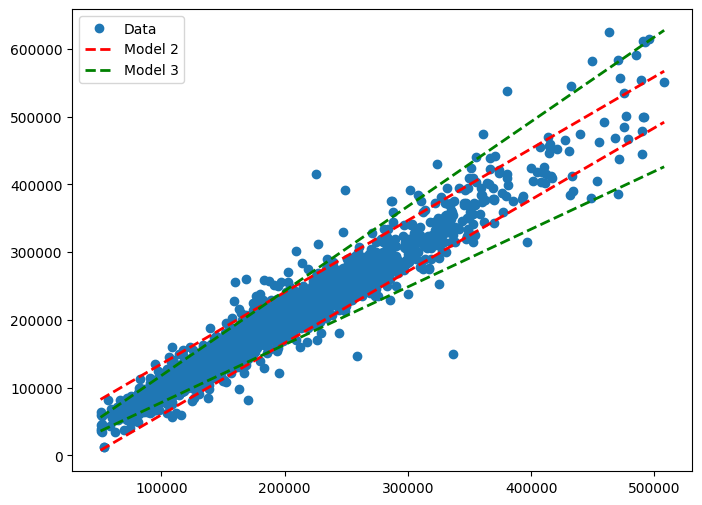

In [99]:
x = df['SalePricePrediction']
y = df['SalePrice']

pred_2 = res2.get_prediction()
iv_l_2 = pred_2.summary_frame()["obs_ci_lower"]
iv_u_2 = pred_2.summary_frame()["obs_ci_upper"]


pred_3 = res3.get_prediction()
iv_l_3 = pred_3.summary_frame()["obs_ci_lower"]
iv_u_3 = pred_3.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, "o", label="Data")

# Model 2
ax.plot(np.sort(x), np.sort(iv_u_2), "r--", label="Model 2", linewidth= 2)
ax.plot(np.sort(x), np.sort(iv_l_2), "r--",  linewidth= 2)

# Model 3
ax.plot(np.sort(x), np.sort(iv_u_3), "g--", label="Model 3", linewidth= 2)
ax.plot(np.sort(x), np.sort(iv_l_3), "g--",  linewidth= 2)
ax.legend(loc="best")
fig.show()

**Confidence intervals do not equal prediction intervals**

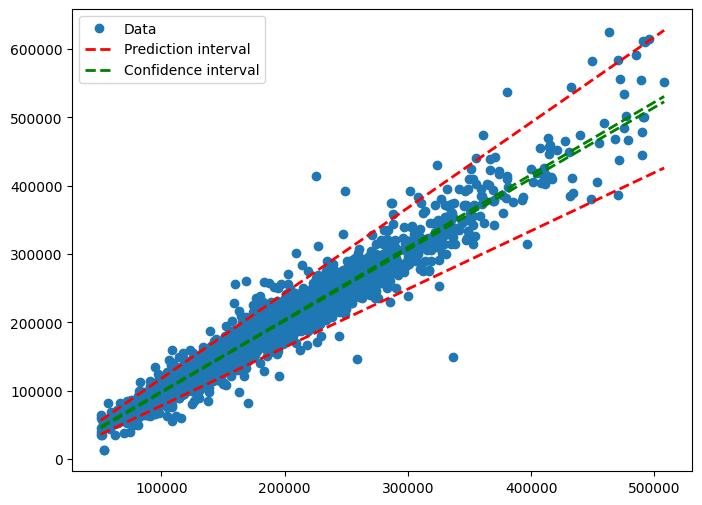

In [100]:
x = df['SalePricePrediction']
y = df['SalePrice']

pred_3 = res3.get_prediction()
iv_l_3 = pred_3.summary_frame()["obs_ci_lower"]
iv_u_3 = pred_3.summary_frame()["obs_ci_upper"]

civ_l_3 = pred_3.summary_frame()["mean_ci_lower"]
civ_u_3 = pred_3.summary_frame()["mean_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, "o", label="Data")

# Prediction intervals
ax.plot(np.sort(x), np.sort(iv_u_3), "r--", label="Prediction interval", linewidth= 2)
ax.plot(np.sort(x), np.sort(iv_l_3), "r--",  linewidth= 2)

# Confidence intervals
ax.plot(np.sort(x), np.sort(civ_u_3), "g--", label="Confidence interval", linewidth= 2)
ax.plot(np.sort(x), np.sort(civ_l_3), "g--",  linewidth= 2)
ax.legend(loc="best")
fig.show()

****